In [42]:
from astrowidgets import ImageWidget
from astrowidgets import ImageWidget
import random
import numpy as np
from astropy.modeling.models import Moffat2D, Gaussian2D
from astropy.convolution import discretize_model
from astropy.table import QTable
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from IPython.display import display
from astrowidgets import ImageWidget
import torch

def plot_image(img):
    image = ImageWidget(image_width=500, image_height=500)
    image.load_array(img)
    image.click_center = True
    display(image)
    return image


def readout_noise(output_shape, ron, gain=1, seed=None):
    '''
    Create readout noise pattern image

    Parameters
    ----------
    output_shape : tuple
        Shape of output image
    ron : float
        Readout noise in electrons
    gain : float
        Gain in electrons per ADU
    seed : int
        Seed for random number generator

    Returns
    -------
    output : array_like
        Readout noise pattern
    '''
    noise_rng = np.random.default_rng(seed)
    output = noise_rng.normal(scale=ron/gain, size=output_shape)
    return output

def dark_current(output_shape, dc, exptime=10, gain=1, hot_pixels=0, seed=None):
    '''
    Create dark current pattern image

    Parameters
    ----------
    output_shape : tuple
        Shape of output image
    dc : float
        Dark current in electrons per pixel per second
    exptime : float
        Exposure time in seconds
    gain : float
        Gain in electrons per ADU
    hot_pixels : float
        Fraction of hot pixels
    seed : int
        Seed for random number generator

    Returns
    -------
    output : array_like
        Dark current pattern
    '''

    noise_rng = np.random.default_rng(seed)
    base_current = dc * exptime / gain
    output = noise_rng.poisson(base_current, size=output_shape)

    if hot_pixels:
        y_max, x_max = output_shape
        n_hot = int(hot_pixels * x_max * y_max)
        hot_x = noise_rng.uniform(0, x_max, size=n_hot).astype(int)
        hot_y = noise_rng.uniform(0, y_max, size=n_hot).astype(int)
        hot_val = 10000 * dc * exptime / gain
        output[(hot_y, hot_x)] = hot_val * noise_rng.normal(size=n_hot)

    return output


def sky_background(output_shape, back_level, gain=1, seed=None):
    '''
    Parameters
    ----------
    output_shape : tuple
        Shape of output image
    back_level : float
        Sky background level in ADU per pixel
    gain : float
        Gain in electrons per ADU
    seed : int
        Seed for random number generator

    Returns
    -------
    output : array_like
        Sky background pattern
    '''
    noise_rng = np.random.default_rng(seed)
    output = noise_rng.poisson(back_level*gain, size=output_shape) / gain
    return output

class Stars:
    def __init__(self, output_shape, model_params, nstars, seed=None):
        self.nstars = nstars
        self.rng = np.random.default_rng(seed)
        self.border = 5
        self.output_shape = output_shape
        if model_params['type'] == 'moffat':
            self.model = Moffat2D()
            self.alpha, self.beta = self.moffat_fwhm_to_alpha(model_params['fwhm'])
        elif model_params['type'] == 'gaussian':
            self.model = Gaussian2D()
            self.fwhm = model_params['fwhm']

    def make_random_models_table(self, params):
        sources = QTable()
        for param_name, (lower, upper, dist) in params.items():
            if dist == 'uni': sources[param_name] = self.rng.uniform(lower, upper, self.nstars)
            elif dist == 'pow': sources[param_name] = upper + lower - self.rng.power(50, self.nstars) * upper
        return sources

    def make_model_sources_image(self, source_table, oversample=1):

        image = np.zeros(self.output_shape, dtype=float)
        yidx, xidx = np.indices(self.output_shape)

        params_to_set = []
        for param in source_table.colnames:
            if param in self.model.param_names:
                params_to_set.append(param)
        init_params = {param: getattr(self.model, param) for param in params_to_set}

        try:
            flux = []
            for source in source_table:
                for param in params_to_set:
                    setattr(self.model, param, source[param])
                if oversample == 1:
                    s = self.model(xidx, yidx)*4
                    image += s
                    flux.append(np.sum(s))
                else:
                    image += discretize_model(self.model, (0, self.output_shape[1]),
                                            (0, self.output_shape[0]), mode='oversample',
                                            factor=oversample)
        finally:
            for param, value in init_params.items():
                setattr(self.model, param, value)

        return image, flux
    

    def create_stars(self, amp_range, ZP=21):

        param_ranges = {'amplitude': [amp_range[0], amp_range[1], 'pow'],
                        'x_0': [self.border, self.output_shape[1]-self.border, 'uni'],
                        'y_0': [self.border, self.output_shape[0]-self.border, 'uni'],
                        'alpha': [self.beta, self.beta, 'uni'],
                        'gamma': [self.alpha, self.alpha, 'uni']}

        sources = self.make_random_models_table(param_ranges)
        data, flux = self.make_model_sources_image(sources)
        sources['flux'] = flux
        sources['fwhm'] = self.moffat_alpha_to_fwhm(sources['alpha'])
        sources['mag'] = ZP - 2.5 * np.log10(flux)
        sources.rename_column('alpha', 'beta')
        sources.rename_column('gamma', 'alpha')
        return data, sources
    
    def add_additional_source(self, x0, y0, amplitude):

        data = np.zeros(self.output_shape, dtype=float)
        yidx, xidx = np.indices(self.output_shape)

        setattr(self.model, "x_0", x0)
        setattr(self.model, "y_0", y0)
        setattr(self.model, "amplitude", amplitude)

        # If the model is Moffat, set the parameters alpha and beta
        if isinstance(self.model, Moffat2D):
            setattr(self.model, "gamma", self.alpha)
            setattr(self.model, "alpha", self.beta)

        data += self.model(xidx, yidx)
        return data

    @staticmethod
    def moffat_alpha_to_fwhm(alpha, beta=4.765):
        fwhm = 2 * alpha * np.sqrt(2 ** (1/beta) - 1)
        return fwhm
    
    @staticmethod
    def moffat_fwhm_to_alpha(fwhm, beta=4.765):
        alpha = fwhm / (2 * np.sqrt(2**(1/beta) - 1)) 
        return alpha, beta
    
class SyntImage:
    
    def __init__(self, output_shape, back_level, ron, dc, hot_px, gain,
                 exptime, mag_range, ZP, fwhm, nstars, model, seed = None):

        self.output_shape = output_shape
        self.back_level = back_level
        self.ron = ron
        self.dc = dc
        self.hot_px = hot_px
        self.gain = gain
        self.exptime = exptime
        self.mag_range = mag_range
        self.ZP = ZP
        self.fwhm = fwhm
        self.nstars = nstars
        self.model = model
        self.seed = seed

    def create_data(self):

        image = np.zeros(list(self.output_shape))

        # Add background noise sources
        image += readout_noise(self.output_shape, self.ron, self.gain, self.seed)
        image += dark_current(self.output_shape, self.dc, self.exptime, self.gain, self.hot_px, self.seed)
        image += sky_background(self.output_shape, self.back_level, self.gain, self.seed)

        # Add stars
        model_params = {'type': self.model,
                        'fwhm': self.fwhm}
        stars = Stars(self.output_shape, model_params, self.nstars, self.seed)
        data, sources = stars.create_stars(self.mag_range, self.ZP)
        image += data

        return image.astype(np.float32), sources
    
    def add_star(self, x0, y0, amplitude):
        model_params = {'type': self.model,
                        'fwhm': self.fwhm}
        stars = Stars(self.output_shape, model_params, 1, self.seed)
        data = stars.add_additional_source(x0, y0, amplitude)
        return data.astype(np.float32)


    def create_header(self):

        header = fits.header.Header()
        header['NAXIS'] = 2
        header['NAXIS1'] = self.output_shape[0]
        header['NAXIS2'] = self.output_shape[1]
        header['GAIN'] = (self.gain, 'Gain in electrons per ADU')
        header['EXPTIME'] = (self.exptime, 'Exposure time in seconds')
        header['RON'] = (self.ron, 'Readout noise in electrons')
        header['DC'] = (self.dc, 'Dark current in electrons per second per pixel')
        header['SKYFLUX'] = self.back_level
        header['SKYMAG'] = self.ZP - 2.5 * np.log10(self.back_level)
        header['HOTPX'] = (self.hot_px, 'Fraction of hot pixels')
        header['ZP'] = (self.ZP, 'Zero point')
        header['FWHM'] = (self.fwhm, 'FWHM of the stars in pixels')
        header['NSTARS'] = (self.nstars, 'Number of stars')
        header['MAGMIN'] = (self.mag_range[0], 'Minimum star magnitude')
        header['MAGMAX'] = (self.mag_range[1], 'Maximum star magnitude')
        header['MODEL'] = (self.model, 'Model of the star PSF')

        return header
    
    def create_fits(self):
        data, sources = self.create_data()
        header = self.create_header()
        hdu = fits.PrimaryHDU(data, header=header)
        return hdu, sources.to_pandas()

In [43]:
output_shape = (1000, 1000)
back_level = 4
ron = 1
dc = 0.
hot_px = 0
gain = 1
exptime = 120
mag_range = (0.5,0.5)
ZP = 0
fwhm = 3
nstars = 1
model = 'moffat'
seed = 1

N = 12
x0 = 220
y0 = 220
dpx = 80
dt = 10 # s
amp = 10
pa = 90

vel = dpx/(dt*N) # px/s
vx = vel*np.cos(pa*np.pi/180)
vy = vel*np.sin(pa*np.pi/180)

pa2 = 45
vx2 = vel*np.cos(pa2*np.pi/180)
vy2 = vel*np.sin(pa2*np.pi/180)


dataset = np.zeros((N, output_shape[0], output_shape[1]))
for i in range(N):
    synt_image = SyntImage(output_shape, back_level, ron+np.random.rand()*3, dc, hot_px, gain, exptime, mag_range, ZP, fwhm+np.random.rand()*1, nstars, model, seed = seed)
    ima = synt_image.create_data()[0]-back_level

    x = x0 + vx*i*dt
    y = y0 + vy*i*dt
    star = synt_image.add_star(x, y, amp)
    ima += star

    x2 = x0 + vx2*i*dt
    y2 = y0 + vy2*i*dt
    star2 = synt_image.add_star(x2, y2, amp/1.2)
    ima += star2

    dataset[i,:] = ima

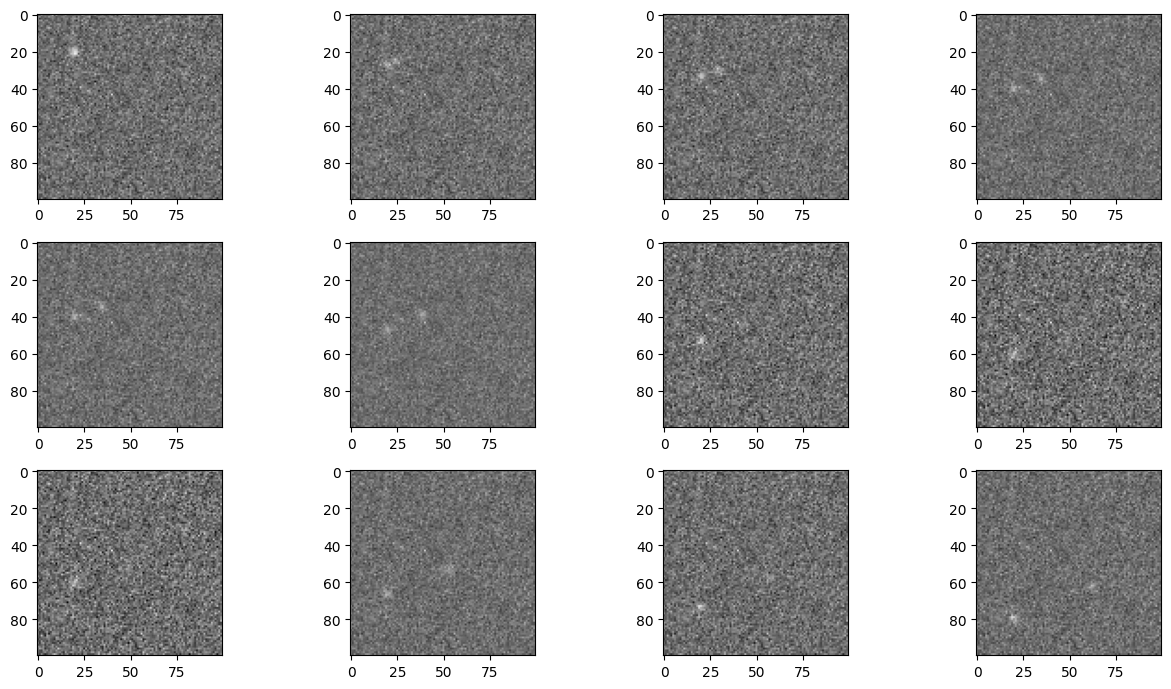

In [44]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 4, figsize=(13, 7))

for i in range(3):
    for j in range(4):
            ax[i,j].imshow(dataset[i*3+j,200:300,200:300], cmap='gray', vmin=-15, vmax=20)
            # ax[i,j].axis('off')

plt.tight_layout()
plt.show()

-- --
## Brute-force
-- --

In [45]:
image = plot_image(ima[200:300,200:300])

ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

In [46]:
import cupy as cp

def compute_trajectories(H, W, velocity, angle, dt_array):
    y_grid, x_grid = cp.mgrid[:H, :W]
    vx = velocity * cp.cos(angle)
    vy = velocity * cp.sin(angle)
    
    x_traj = x_grid[:, :, cp.newaxis] + vx * dt_array
    y_traj = y_grid[:, :, cp.newaxis] + vy * dt_array
    return x_traj, y_traj

def search_moving_object(dataset, vel_range, pa_range, dt_array):
    N, H, W = dataset.shape
    n_vel = len(vel_range)
    n_pa = len(pa_range)
    
    likelihoods = cp.zeros((H, W, n_vel, n_pa))
    
    for v, velocity in enumerate(vel_range):
        for p, angle in enumerate(pa_range):
            x_traj, y_traj = compute_trajectories(H, W, velocity, angle, dt_array)
            
            mask = (x_traj >= 0) & (x_traj < W) & (y_traj >= 0) & (y_traj < H)
            x_traj = cp.where(mask, x_traj, 0).astype(int)
            y_traj = cp.where(mask, y_traj, 0).astype(int)

            trajectory_values = dataset[cp.arange(N), x_traj, y_traj]

            mask_adjusted = mask.transpose(2, 0, 1)
            trajectory_values = trajectory_values * mask_adjusted
            likelihood = cp.sum(trajectory_values, axis=0)
            likelihoods[:, :, v, p] = likelihood

    
    max_likelihood = cp.max(likelihoods)
    max_position = cp.unravel_index(cp.argmax(likelihoods), likelihoods.shape)
    
    return max_likelihood, max_position





-- --
### PyTorch

In [47]:
import torch

def get_trajectory_indices(vel, pa, dt_array, image_shape, device):
    y_grid, x_grid = torch.meshgrid(torch.arange(image_shape[0], device=device), torch.arange(image_shape[1], device=device))
    dx = (vel * dt_array * torch.cos(torch.deg2rad(pa))).long()
    dy = (vel * dt_array * torch.sin(torch.deg2rad(pa))).long()
    x_coords = (x_grid[None, :, :] + dx[:, None, None]).clamp(min=0, max=image_shape[1]-1)
    y_coords = (y_grid[None, :, :] + dy[:, None, None]).clamp(min=0, max=image_shape[0]-1)
    valid_x = (x_coords >= 0) & (x_coords < image_shape[1])
    valid_y = (y_coords >= 0) & (y_coords < image_shape[0])
    valid = valid_x & valid_y
    del valid_x, valid_y
    return x_coords, y_coords, valid

def get_trajectory_values(data, x_coords, y_coords, valid):
    prob_values = torch.zeros_like(data[0])
    for t in range(data.shape[0]):
        prob_values += torch.where(valid[t], data[t, y_coords[t], x_coords[t]], torch.tensor(0.0, dtype=torch.float32))
    return prob_values

def compute_all_trajectories(data, vel_range, pa_range, dt_array):
    image_shape = data.shape[1:]
    probs_tensor = torch.zeros(*image_shape, len(vel_range), len(pa_range), device=data.device)
    for v_idx, vel in enumerate(vel_range):
        for pa_idx, pa in enumerate(pa_range):
            x_coords, y_coords, valid = get_trajectory_indices(vel, pa, dt_array, image_shape, data.device)
            prob_values = get_trajectory_values(data, x_coords, y_coords, valid)
            probs_tensor[:,:,v_idx,pa_idx] = prob_values
    del x_coords, y_coords, valid, prob_values
    torch.cuda.empty_cache()
    return probs_tensor



In [48]:
device = torch.device("cuda:2")# if torch.cuda.is_available() else "cpu")

vel_range = torch.arange(0.3, 1.2, 0.01).to(device)
pa_range = torch.arange(0, 120, 1).to(device)
dt_array = torch.arange(0, N, dtype=torch.float32).to(device) * dt
data = torch.tensor(dataset, dtype=torch.float32).to(device)
data = torch.abs(data)


In [ ]:
probs = compute_all_trajectories(data, vel_range, pa_range, dt_array)

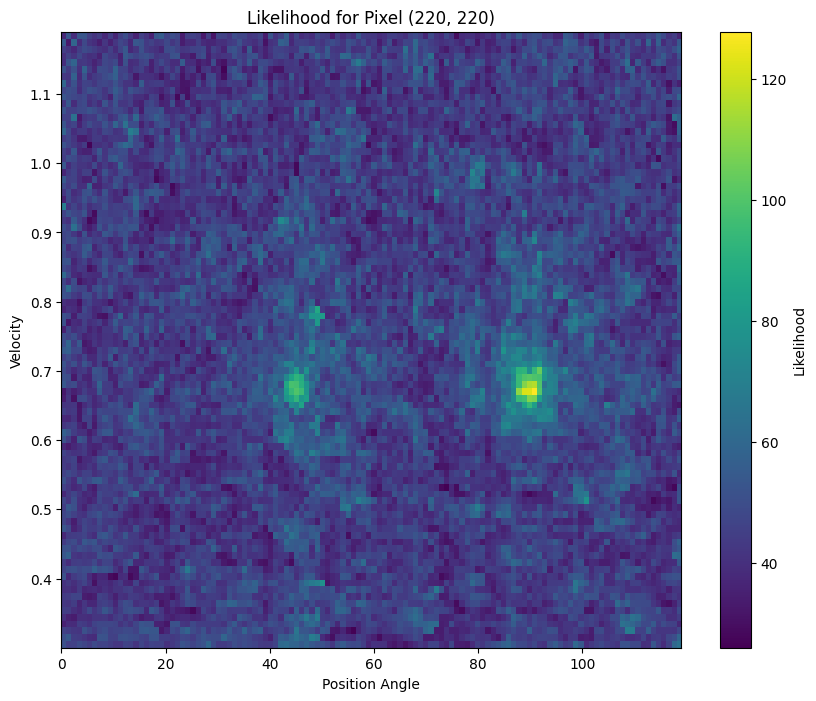

In [ ]:
# plot likelihoods of x0 y0 pixel
plt.figure(figsize=(10, 8))
likelihood_pixel = probs[y0, x0, :, :].cpu().numpy()
plt.imshow(likelihood_pixel, extent=[pa_range.min().item(), pa_range.max().item(), vel_range.min().item(), vel_range.max().item()], aspect='auto', origin='lower')
plt.colorbar(label='Likelihood')
plt.xlabel('Position Angle')
plt.ylabel('Velocity')
plt.title(f'Likelihood for Pixel ({y0}, {x0})')
plt.show()

In [49]:
del probs, data, vel_range, pa_range, dt_array
torch.cuda.empty_cache()

NameError: name 'probs' is not defined

In [ ]:
!nvidia-smi

Thu Oct  5 01:08:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:17:00.0 Off |                    0 |
| N/A   47C    P0    78W / 200W |  47447MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:31:00.0 Off |                    0 |
| N/A   

-- --
## HMC
-- --

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

def compute_log_likelihood(vel, pa, data, dt_array):
    image_shape = data.shape[1:]
    x_coords, y_coords, valid = get_trajectory_indices(vel, pa, dt_array, image_shape, data.device)
    prob_values = get_trajectory_values(data, x_coords, y_coords, valid)
    return prob_values


def model(data, dt_array):
    vel = pyro.sample("vel", dist.Uniform(0.3, 1.2))
    pa = pyro.sample("pa", dist.Uniform(0, 120))
    
    log_likelihood = compute_log_likelihood(vel, pa, data, dt_array)
    
    pyro.sample("obs", dist.Normal(log_likelihood, 1.0), obs=log_likelihood)

def perform_hmc_inference(data, dt_array, vel_range, pa_range):
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=0)
    mcmc.run(data, dt_array)
    
    posterior_samples = mcmc.get_samples()
    return posterior_samples



In [ ]:
posterior_samples = perform_hmc_inference(data, dt_array, vel_range, pa_range)

Warmup:   0%|          | 0/1000 [00:00, ?it/s]

RuntimeError: The size of tensor a (1000) must match the size of tensor b (12) at non-singleton dimension 1
Trace Shapes:            
 Param Sites:            
Sample Sites:            
     vel dist | 1000 1000
        value | 1000 1000
      pa dist | 1000 1000
        value | 1000 1000

In [ ]:
def compute_likelihood_for_pixel(vel, pa, data, dt_array, x0, y0):
    image_shape = data.shape[1:]
    x_coords, y_coords, valid = get_trajectory_indices(vel, pa, dt_array, image_shape, data.device)
    prob_values = get_trajectory_values(data, x_coords, y_coords, valid)
    return prob_values[y0, x0].to(data.device)

def model_for_pixel(data, dt_array, x0, y0):
    vel = pyro.sample("vel", dist.Uniform(0.3, 1.2))
    pa = pyro.sample("pa", dist.Uniform(0, 120))
    log_likelihood = -compute_log_likelihood_for_pixel(vel, pa, data, dt_array, x0, y0)
    pyro.sample("obs", dist.Normal(log_likelihood, 10.), obs=log_likelihood)

def perform_hmc_inference_for_pixel(data, dt_array, x0, y0):
    nuts_kernel = NUTS(model_for_pixel)
    mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=0)
    mcmc.run(data, dt_array, x0, y0)
    posterior_samples = mcmc.get_samples()
    return posterior_samples, mcmc



In [ ]:
posterior_samples, mcmc_instance = perform_hmc_inference_for_pixel(data, dt_array, x0, y0)

log_likelihoods = []
for i in range(len(posterior_samples['vel'])):
    vel_sample = posterior_samples['vel'][i]
    pa_sample = posterior_samples['pa'][i]
    log_likelihood = compute_log_likelihood_for_pixel(vel_sample, pa_sample, data, dt_array, x0, y0)
    log_likelihoods.append(log_likelihood.item())


Sample: 100%|██████████| 1000/1000 [00:10, 98.80it/s, step size=2.00e+00, acc. prob=0.778]


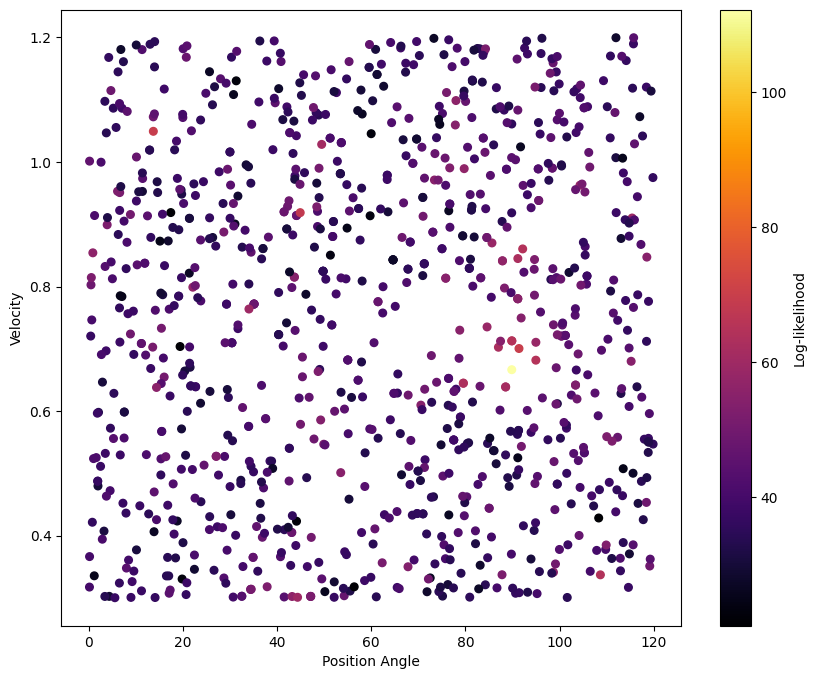

In [ ]:
plt.figure(figsize=(10, 8))
# hist2d, xedges, yedges = np.histogram2d(posterior_samples["pa"].cpu().numpy(), posterior_samples["vel"].cpu().numpy(), bins=100, range=[[0, 120], [0.3, 1.2]])
# plt.imshow(hist2d, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='inferno')
plt.scatter(posterior_samples["pa"].cpu().numpy(), posterior_samples["vel"].cpu().numpy(), c=log_likelihoods, cmap='inferno', s=30)
plt.colorbar(label="Log-likelihood")
plt.xlabel('Position Angle')
plt.ylabel('Velocity')
plt.show()

-- --
### Genetic algorithm

In [ ]:
(1.2-0.3)/0.01 * 120

10799.999999999998

In [ ]:
(1.2*4-0.3)/0.01 * 120*3

162000.0

For 1 pixel 

In [66]:
def compute_likelihood_for_pixel(vel, pa, data, dt_array, x0, y0):
    image_shape = data.shape[1:]
    x_coords, y_coords, valid = get_trajectory_indices(vel, pa, dt_array, image_shape, data.device)
    prob_values = get_trajectory_values(data, x_coords, y_coords, valid)
    return prob_values[y0, x0].to(data.device)

def get_trajectory_indices(vel, pa, dt_array, image_shape, device):
    y_grid, x_grid = torch.meshgrid(torch.arange(image_shape[0], device=device), torch.arange(image_shape[1], device=device))
    dx = (vel * dt_array * torch.cos(torch.deg2rad(pa))).long()
    dy = (vel * dt_array * torch.sin(torch.deg2rad(pa))).long()
    x_coords = (x_grid[None, :, :] + dx[:, None, None]).clamp(min=0, max=image_shape[1]-1)
    y_coords = (y_grid[None, :, :] + dy[:, None, None]).clamp(min=0, max=image_shape[0]-1)
    valid_x = (x_coords >= 0) & (x_coords < image_shape[1])
    valid_y = (y_coords >= 0) & (y_coords < image_shape[0])
    valid = valid_x & valid_y
    del valid_x, valid_y
    return x_coords, y_coords, valid

def get_trajectory_values(data, x_coords, y_coords, valid):
    prob_values = torch.zeros_like(data[0])
    for t in range(data.shape[0]):
        prob_values += torch.where(valid[t], data[t, y_coords[t], x_coords[t]], torch.tensor(0.0, dtype=torch.float32))
    return prob_values


# Parameters
POPULATION_SIZE = 1000
GENE_SIZE = 2 
MUTATION_RATE = 0.01
CROSSOVER_RATE = 0.7
MAX_GENERATIONS = 100
VEL_RANGE = (0.3, 1.2)
PA_RANGE = (0, 120)
SELECTION_SIZE = int(0.2 * POPULATION_SIZE)
OFFSPRING_SIZE = POPULATION_SIZE - SELECTION_SIZE
CONVERGENCE_THRESHOLD_VEL = 0.01
CONVERGENCE_THRESHOLD_PA = 1  
CONVERGENCE_COUNT = 5 

# init
def initialize_population():
    velocities = torch.rand(POPULATION_SIZE, 1) * (VEL_RANGE[1] - VEL_RANGE[0]) + VEL_RANGE[0]
    angles = torch.rand(POPULATION_SIZE, 1) * (PA_RANGE[1] - PA_RANGE[0]) + PA_RANGE[0]
    return torch.cat([velocities, angles], dim=1)

# eval
def evaluate_population(population, data, dt_array, x0, y0):
    fitnesses = torch.zeros(POPULATION_SIZE)
    for i, individual in enumerate(population):
        vel, pa = individual
        likelihood = compute_likelihood_for_pixel(vel, pa, data, dt_array, x0, y0)
        fitnesses[i] = likelihood
    return fitnesses

# selection
def select_parents(population, fitnesses):
    _, indices = fitnesses.topk(SELECTION_SIZE)
    return population[indices]

# crossover
def crossover(parents):
    offspring = torch.zeros(OFFSPRING_SIZE, GENE_SIZE)
    for i in range(0, OFFSPRING_SIZE, 2):
        parent1 = parents[torch.randint(0, SELECTION_SIZE, (1,)).item()]
        parent2 = parents[torch.randint(0, SELECTION_SIZE, (1,)).item()]
        if torch.rand(1) < CROSSOVER_RATE and i < OFFSPRING_SIZE - 1: 
            crossover_point = torch.randint(1, GENE_SIZE, (1,)).item()
            offspring[i] = torch.cat([parent1[:crossover_point], parent2[crossover_point:]])
            offspring[i+1] = torch.cat([parent2[:crossover_point], parent1[crossover_point:]])
        else:
            offspring[i] = parent1
            if i < OFFSPRING_SIZE - 1:
                offspring[i+1] = parent2
    return offspring

# mutation
def mutate(offspring):
    for individual in offspring:
        if torch.rand(1) < MUTATION_RATE:
            gene_to_mutate = torch.randint(0, GENE_SIZE, (1,)).item()
            if gene_to_mutate == 0:
                individual[0] = torch.clamp(individual[0] + torch.randn(1) * 0.1, *VEL_RANGE)
            else:
                individual[1] = torch.fmod(individual[1] + torch.randn(1) * 5, PA_RANGE[1])
    return offspring

# # main
# def run_genetic_algorithm(data, dt_array, x0, y0):
#     population = initialize_population()
#     best_individual = None
#     best_fitness = float('-inf')
    
#     for generation in range(MAX_GENERATIONS):
#         fitnesses = evaluate_population(population, data, dt_array, x0, y0)
#         parents = select_parents(population, fitnesses)
#         offspring = crossover(parents)
#         offspring = mutate(offspring)
        
#         # population replacement
#         population[:SELECTION_SIZE] = parents
#         population[SELECTION_SIZE:] = offspring
        
#         gen_best_fitness, gen_best_idx = fitnesses.max(0)
#         if gen_best_fitness > best_fitness:
#             best_fitness = gen_best_fitness
#             best_individual = population[gen_best_idx]
    
#     return best_individual, best_fitness

# # ouput log
# def run_genetic_algorithm_with_logging(data, dt_array, x0, y0):
#     population = initialize_population()
#     best_individual = None
#     best_fitness = float('-inf')
    
#     population_history = []
#     fitness_history = []
    
#     for generation in range(MAX_GENERATIONS):
#         fitnesses = evaluate_population(population, data, dt_array, x0, y0)
        
#         population_history.append(population.clone())
#         fitness_history.append(fitnesses.clone())
        
#         parents = select_parents(population, fitnesses)
#         offspring = crossover(parents)
#         offspring = mutate(offspring)
        
#         population[:SELECTION_SIZE] = parents
#         population[SELECTION_SIZE:] = offspring
        
#         gen_best_fitness, gen_best_idx = fitnesses.max(0)
#         if gen_best_fitness > best_fitness:
#             best_fitness = gen_best_fitness
#             best_individual = population[gen_best_idx]
    
#     return best_individual, best_fitness, population_history, fitness_history


# Convergence stop

def run_genetic_algorithm_with_convergence(data, dt_array, x0, y0):
    population = initialize_population()
    best_individual = None
    best_fitness = float('-inf')
    
    population_history = []
    fitness_history = []
    
    convergence_counter = 0
    for generation in range(MAX_GENERATIONS):
        fitnesses = evaluate_population(population, data, dt_array, x0, y0)
        
        population_history.append(population.clone())
        fitness_history.append(fitnesses.clone())
        
        # check convergence
        vel_variation = population[:, 0].std()
        pa_variation = population[:, 1].std()
        if vel_variation < CONVERGENCE_THRESHOLD_VEL and pa_variation < CONVERGENCE_THRESHOLD_PA:
            convergence_counter += 1
            if convergence_counter >= CONVERGENCE_COUNT:
                break
        else:
            convergence_counter = 0
        
        parents = select_parents(population, fitnesses)
        offspring = crossover(parents)
        offspring = mutate(offspring)

        population[:SELECTION_SIZE] = parents
        population[SELECTION_SIZE:] = offspring
        
        gen_best_fitness, gen_best_idx = fitnesses.max(0)
        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_individual = population[gen_best_idx]
    
    return best_individual, best_fitness, population_history, fitness_history, generation





In [ ]:
best_individual, best_fitness = run_genetic_algorithm(data, dt_array, x0, y0)


In [67]:
# x0 = torch.tensor(220, dtype=torch.long).to(device)
# y0 = torch.tensor(220, dtype=torch.long).to(device)
best_individual, best_fitness, population_history, fitness_history, convergence_generation = run_genetic_algorithm_with_convergence(data, dt_array, x0, y0)

In [68]:
print(best_individual)
print(vel, pa)
print(best_fitness)
print(convergence_generation)


tensor([ 0.6771, 91.3856])
0.6666666666666666 90
tensor(134.6423)
9


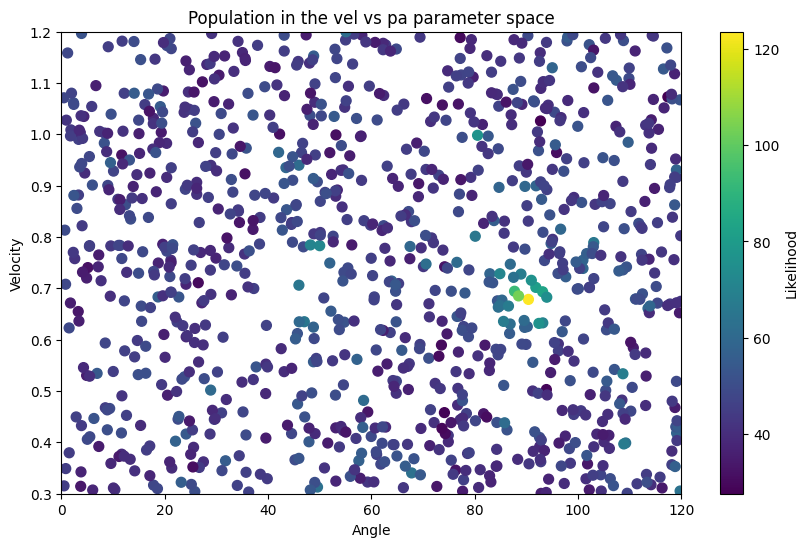

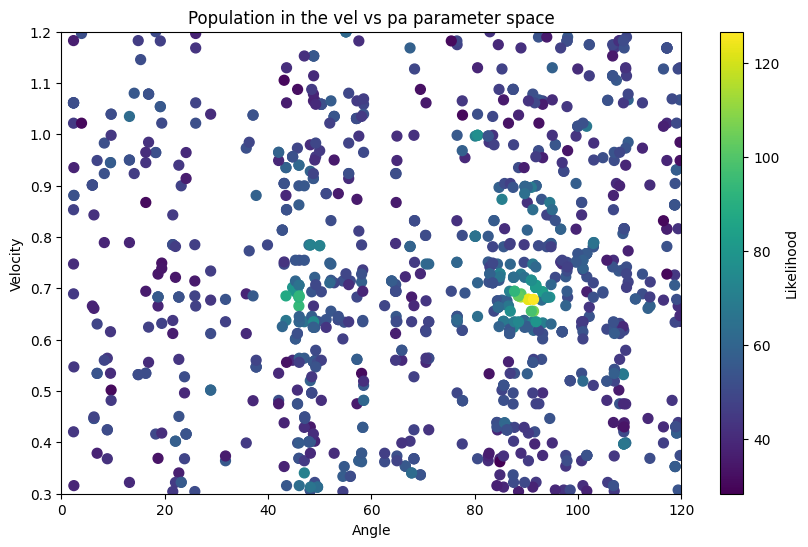

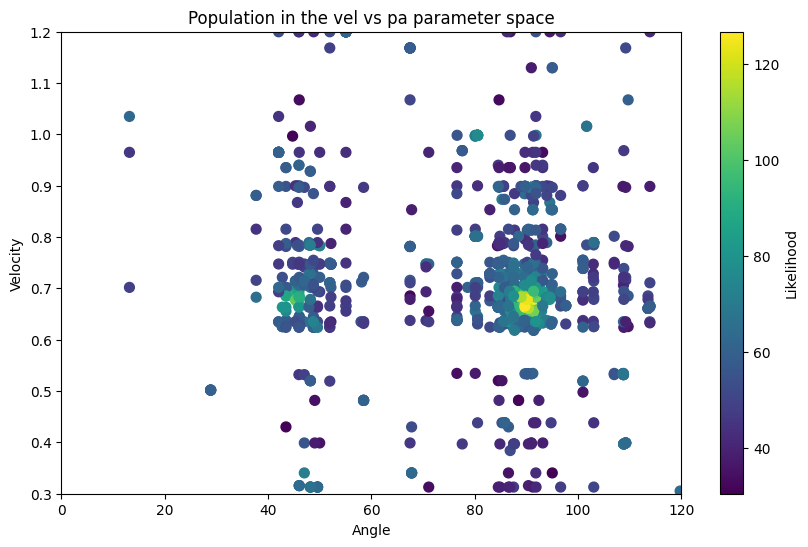

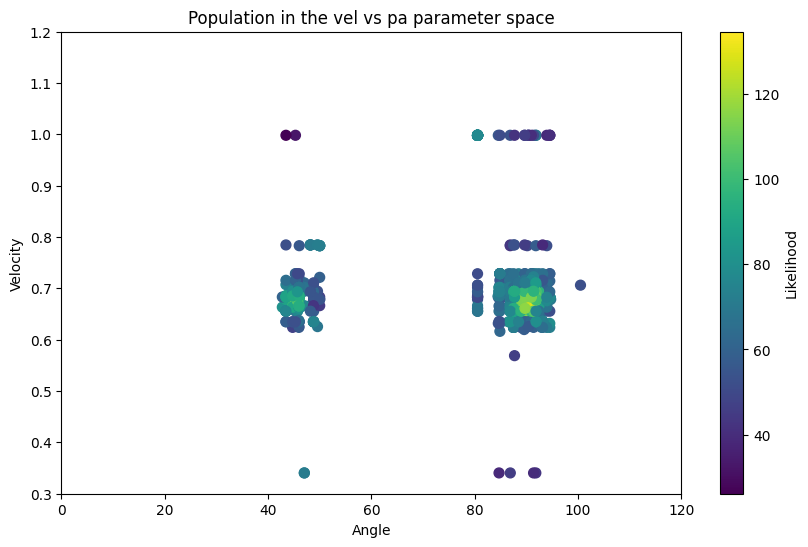

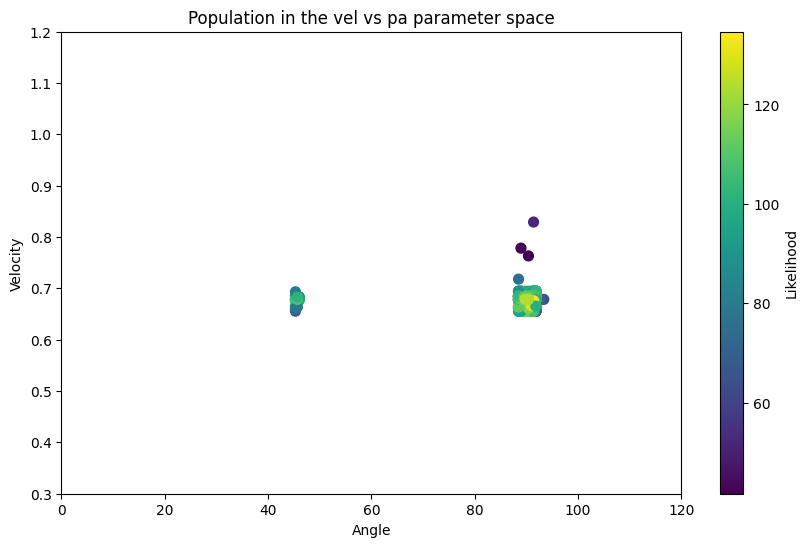

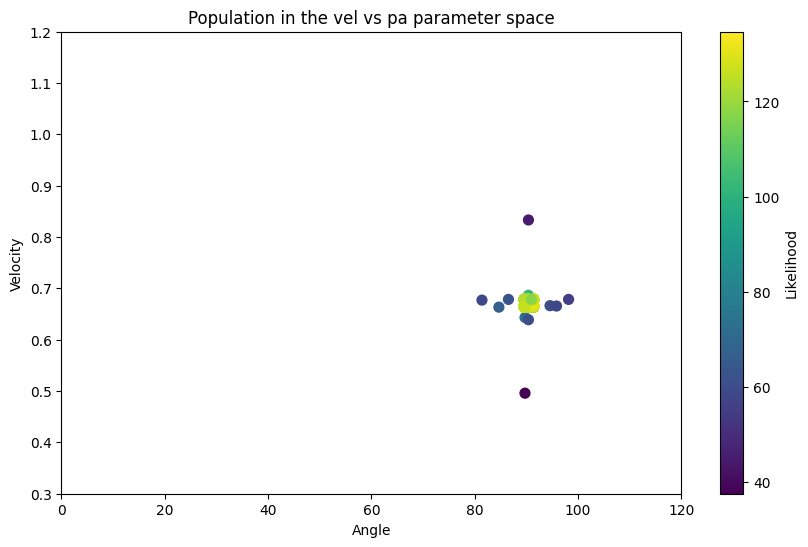

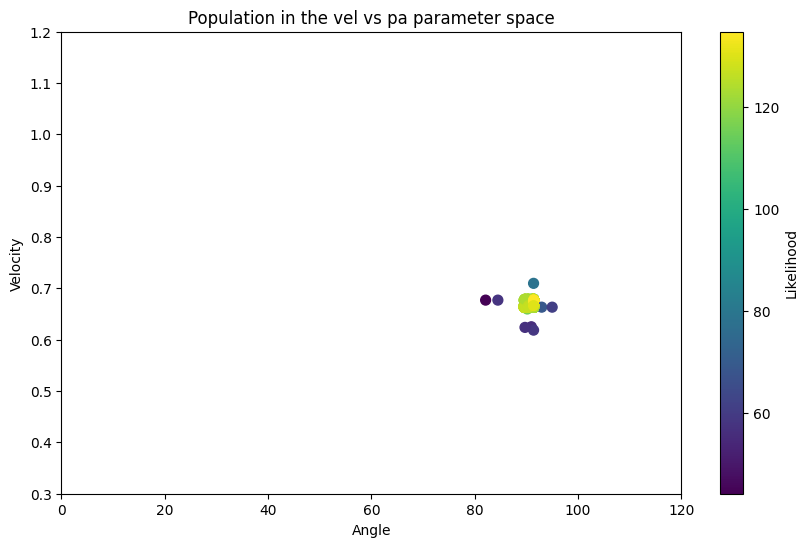

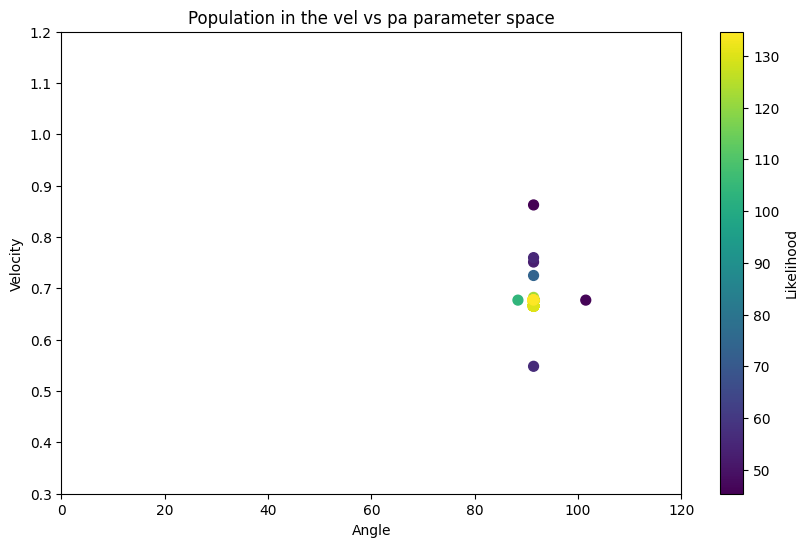

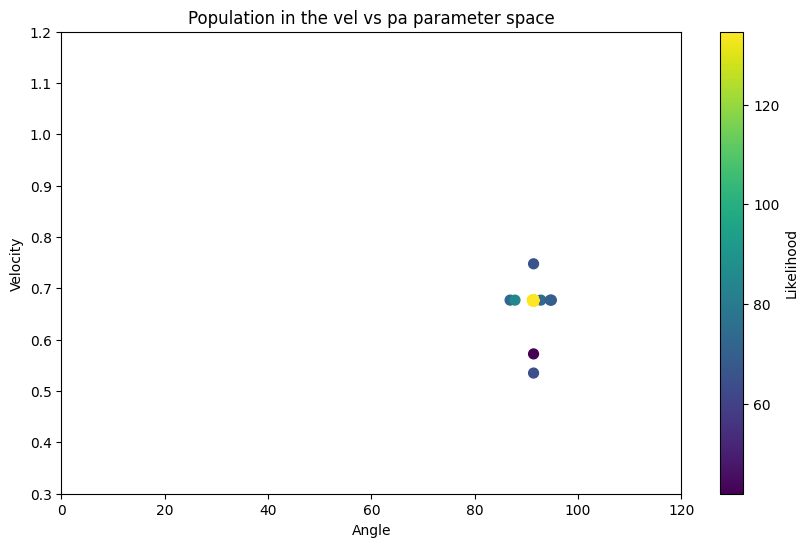

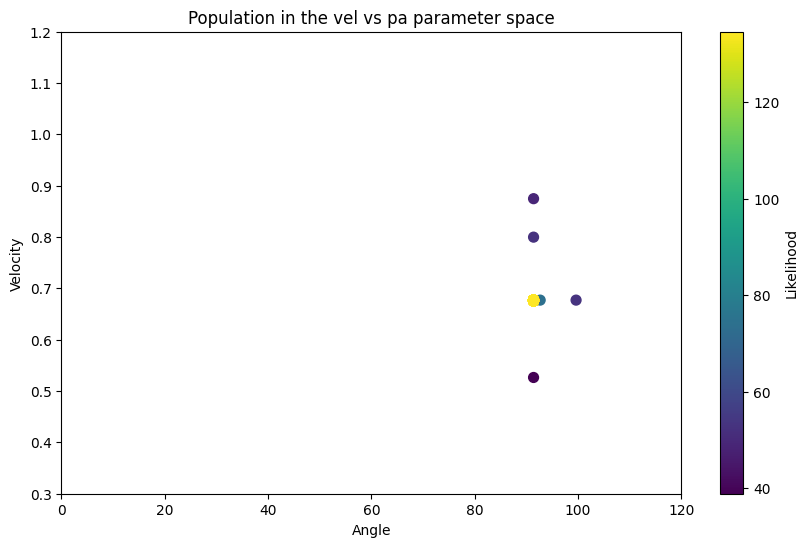

IndexError: list index out of range

In [71]:
import matplotlib.pyplot as plt

def plot_population(population, fitnesses):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Scatter plot
    scatter = ax.scatter(population[:, 1], population[:, 0], c=fitnesses, cmap='viridis', s=50)
    cbar = plt.colorbar(scatter, ax=ax)
    
    ax.set_title("Population in the vel vs pa parameter space")
    ax.set_ylabel("Velocity")
    ax.set_xlabel("Angle")
    cbar.set_label('Likelihood')
    ax.set_xlim(PA_RANGE)
    ax.set_ylim(VEL_RANGE)
    plt.savefig(f'genetic_algorithm_{i}.png')
    
    plt.show()


for i in range(0, MAX_GENERATIONS, 1):
    plot_population(population_history[i], fitness_history[i])



In [ ]:
def compute_likelihood_for_pixel(vel, pa, data, dt_array, x0, y0):
    image_shape = data.shape[1:]
    x_coords, y_coords, valid = get_trajectory_indices(vel, pa, dt_array, image_shape, data.device)
    prob_values = get_trajectory_values(data, x_coords, y_coords, valid)
    return prob_values[y0, x0].to(data.device)

def get_trajectory_indices(vel, pa, dt_array, image_shape, device):
    y_grid, x_grid = torch.meshgrid(torch.arange(image_shape[0], device=device), torch.arange(image_shape[1], device=device))
    dx = (population[..., 0, None, None] * dt_array[:, None, None, None] * torch.cos(torch.deg2rad(population[..., 1, None, None]))).long()
    dy = (population[..., 0, None, None] * dt_array[:, None, None, None] * torch.sin(torch.deg2rad(population[..., 1, None, None]))).long()
    x_coords = (x_grid[None, None, :, :] + dx).clamp(min=0, max=image_shape[1]-1)
    y_coords = (y_grid[None, None, :, :] + dy).clamp(min=0, max=image_shape[0]-1)
    valid_x = (x_coords >= 0) & (x_coords < image_shape[1])
    valid_y = (y_coords >= 0) & (y_coords < image_shape[0])
    valid = valid_x & valid_y
    del valid_x, valid_y
    return x_coords, y_coords, valid

def get_trajectory_values(data, x_coords, y_coords, valid):
    prob_values = torch.zeros_like(data[0])
    for t in range(data.shape[0]):
        prob_values += torch.where(valid[t], data[t, y_coords[t], x_coords[t]], torch.tensor(0.0, dtype=torch.float32))
    return prob_values

All the image

In [ ]:
import gc

def initialize_population_for_all_pixels(image_shape):
    velocities = torch.rand(image_shape[0], image_shape[1], POPULATION_SIZE, 1) * (VEL_RANGE[1] - VEL_RANGE[0]) + VEL_RANGE[0]
    angles = torch.rand(image_shape[0], image_shape[1], POPULATION_SIZE, 1) * (PA_RANGE[1] - PA_RANGE[0]) + PA_RANGE[0]
    return torch.cat([velocities, angles], dim=-1).to(device)

def evaluate_population_for_each_pixel(population, data, dt_array):
    image_shape = data.shape[1:]
    fitnesses = torch.zeros(*image_shape, POPULATION_SIZE)
    for y in range(image_shape[0]):
        for x in range(image_shape[1]):
            for i, individual in enumerate(population[y, x]):
                vel, pa = individual
                likelihood = compute_likelihood_for_pixel(vel, pa, data, dt_array, x, y)
                fitnesses[y, x, i] = likelihood
    return fitnesses

def select_parents_for_each_pixel(population, fitnesses):
    _, indices = fitnesses.topk(SELECTION_SIZE, dim=-1)
    parents = torch.gather(population, 2, indices.unsqueeze(-1).expand(*indices.shape, 2))
    return parents





def get_trajectory_indices_for_population(population, dt_array, image_shape, device):
    population = population.to(device)
    dt_array = dt_array.to(device)

    num_individuals = population.shape[2]
    y_grid, x_grid = torch.meshgrid(torch.arange(image_shape[0], device=device), torch.arange(image_shape[1], device=device))
    
    dx = (population[..., 0] * dt_array[:, None, None, None] * torch.cos(torch.deg2rad(population[..., 1]))).to(device).long()
    dy = (population[..., 0] * dt_array[:, None, None, None] * torch.sin(torch.deg2rad(population[..., 1]))).to(device).long()
    
    x_coords = (x_grid[None, :, :, None] + dx).clamp(min=0, max=image_shape[1]-1)
    y_coords = (y_grid[None, :, :, None] + dy).clamp(min=0, max=image_shape[0]-1)
    
    valid_x = (x_coords >= 0) & (x_coords < image_shape[1])
    valid_y = (y_coords >= 0) & (y_coords < image_shape[0])
    valid = valid_x & valid_y

    del valid_x, valid_y, dx, dy
    gc.collect()
    torch.cuda.empty_cache()
    
    return x_coords, y_coords, valid

def get_trajectory_values_for_population(data, x_coords, y_coords, valid):
    num_times, height, width, num_individuals = x_coords.shape
    prob_values = torch.zeros((height, width, num_individuals), device=data.device)
    for t in range(num_times):
        prob_values.add_(torch.where(valid[t], data[t, y_coords[t], x_coords[t]], torch.tensor(0.0, dtype=torch.float32, device=data.device)))
    del x_coords, y_coords, valid
    gc.collect()
    torch.cuda.empty_cache()
    return prob_values


def evaluate_population_for_all_pixels(population, data, dt_array):
    image_shape = data.shape[1:3]
    x_coords, y_coords, valid = get_trajectory_indices_for_population(population, dt_array, image_shape, data.device)
    fitnesses = get_trajectory_values_for_population(data, x_coords, y_coords, valid)
    gc.collect()
    torch.cuda.empty_cache()
    return fitnesses


def crossover_for_each_pixel(parents):
    image_shape = parents.shape[:-1]  # Exclude the gene dimension
    offspring = torch.zeros((*image_shape, OFFSPRING_SIZE, GENE_SIZE), device=parents.device)

    for i in range(0, OFFSPRING_SIZE, 2):
        parent1_idx = torch.randint(0, SELECTION_SIZE, (*image_shape, 1), device=parents.device)
        parent2_idx = torch.randint(0, SELECTION_SIZE, (*image_shape, 1), device=parents.device)
        
        parent1 = torch.gather(parents, -1, parent1_idx.expand(*image_shape, GENE_SIZE))
        parent2 = torch.gather(parents, -1, parent2_idx.expand(*image_shape, GENE_SIZE))
        
        do_crossover = torch.rand(*image_shape) < CROSSOVER_RATE
        crossover_points = torch.where(do_crossover, torch.randint(1, GENE_SIZE, image_shape, device=parents.device), 0)
        
        offspring[..., i, :crossover_points] = parent1[..., :crossover_points]
        offspring[..., i, crossover_points:] = parent2[..., crossover_points:]
        
        if i < OFFSPRING_SIZE - 1:
            offspring[..., i+1, :crossover_points] = parent2[..., :crossover_points]
            offspring[..., i+1, crossover_points:] = parent1[..., crossover_points:]
            
            # Handle the case where we don't crossover
            no_crossover_mask = ~do_crossover
            offspring[no_crossover_mask, i+1] = parent1[no_crossover_mask]
    
    return offspring





def run_genetic_algorithm_with_convergence_for_all_pixels(data, dt_array):
    image_shape = data.shape[1:]
    population = initialize_population_for_all_pixels(image_shape)
    best_individuals = torch.zeros(*image_shape, GENE_SIZE)
    best_fitnesses = torch.full(image_shape, float('-inf'))

    convergence_counter = torch.zeros(*image_shape, dtype=torch.int).to('cpu')
    for generation in range(MAX_GENERATIONS):
        print(f'Generation {generation}')


        fitnesses = evaluate_population_for_all_pixels(population, data, dt_array)
        print('Evaluated fitnesses')

        # check convergence
        vel_variation = population[..., 0].std(dim=-1)
        pa_variation = population[..., 1].std(dim=-1)

        convergence_mask = ((vel_variation < CONVERGENCE_THRESHOLD_VEL) & (pa_variation < CONVERGENCE_THRESHOLD_PA)).to('cpu')
        convergence_counter[convergence_mask] += 1
        non_convergence_mask = ~convergence_mask
        convergence_counter[non_convergence_mask] = 0

        if torch.all(convergence_counter >= CONVERGENCE_COUNT):
            break
        print('Checked convergence')

        parents = select_parents_for_each_pixel(population, fitnesses)
        print('Selected parents')
        offspring = crossover(parents.view(-1, GENE_SIZE)).view(*image_shape, OFFSPRING_SIZE, GENE_SIZE)
        print('Crossovered')
        offspring = mutate(offspring.view(-1, GENE_SIZE)).view(*image_shape, OFFSPRING_SIZE, GENE_SIZE)
        print('Mutated')

        population[..., :SELECTION_SIZE, :] = parents
        population[..., SELECTION_SIZE:, :] = offspring


        max_fitness, _ = fitnesses.max(-1)
        best_fitnesses_mask = max_fitness > best_fitnesses
        best_fitnesses[best_fitnesses_mask] = max_fitness[best_fitnesses_mask]
        best_individuals[best_fitnesses_mask] = population[best_fitnesses_mask]
        print('Updated best fitnesses')

        del fitnesses, parents, offspring, max_fitness, best_fitnesses_mask
        gc.collect()
        torch.cuda.empty_cache()

    del population, convergence_counter
    gc.collect()
    torch.cuda.empty_cache()

    return best_individuals, best_fitnesses


In [ ]:
best_individuals, best_fitnesses = run_genetic_algorithm_with_convergence_for_all_pixels(data, dt_array)


Generation 0
Evaluated fitnesses
Checked convergence
Selected parents


KeyboardInterrupt: 

muy lento

-- --
### MCMC

In [59]:
import pyro
import pyro.distributions as dist
import torch
from pyro.infer import MCMC, NUTS  # NUTS es una variante de HMC

def compute_likelihood_for_pixel(vel, pa, data, dt_array, x0, y0):
    image_shape = data.shape[1:]
    x_coords, y_coords, valid = get_trajectory_indices(vel, pa, dt_array, image_shape, data.device)
    prob_values = get_trajectory_values(data, x_coords, y_coords, valid)
    return prob_values[y0, x0].to(data.device)

def get_trajectory_indices(vel, pa, dt_array, image_shape, device):
    y_grid, x_grid = torch.meshgrid(torch.arange(image_shape[0], device=device), torch.arange(image_shape[1], device=device))
    dx = (vel * dt_array * torch.cos(torch.deg2rad(pa))).long()
    dy = (vel * dt_array * torch.sin(torch.deg2rad(pa))).long()
    x_coords = (x_grid[None, :, :] + dx[:, None, None]).clamp(min=0, max=image_shape[1]-1)
    y_coords = (y_grid[None, :, :] + dy[:, None, None]).clamp(min=0, max=image_shape[0]-1)
    valid_x = (x_coords >= 0) & (x_coords < image_shape[1])
    valid_y = (y_coords >= 0) & (y_coords < image_shape[0])
    valid = valid_x & valid_y
    del valid_x, valid_y
    return x_coords, y_coords, valid

def get_trajectory_values(data, x_coords, y_coords, valid):
    prob_values = torch.zeros_like(data[0])
    for t in range(data.shape[0]):
        prob_values += torch.where(valid[t], data[t, y_coords[t], x_coords[t]], torch.tensor(0.0, dtype=torch.float32))
    return prob_values

def model(data, dt_array, x0, y0):
    vel = pyro.sample("vel", dist.Uniform(VEL_RANGE[0], VEL_RANGE[1]))
    pa = pyro.sample("pa", dist.Uniform(PA_RANGE[0], PA_RANGE[1]))
    
    log_likelihood_val = -compute_likelihood_for_pixel(vel, pa, data, dt_array, x0, y0)
    pyro.factor("obs", log_likelihood_val)
    

def run_mcmc(data, dt_array, x0, y0, num_samples=200):
    nuts_kernel = NUTS(model, step_size=0.1, adapt_step_size=True)
    mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=10)
    mcmc.run(data, dt_array, x0, y0)
    return mcmc.get_samples()


In [ ]:
def compute_likelihood_for_pixel(vel, pa, data, dt_array, x0, y0):
    image_shape = data.shape[1:]
    x_coords, y_coords, valid = get_trajectory_indices(vel, pa, dt_array, image_shape, data.device)
    prob_values = get_trajectory_values(data, x_coords, y_coords, valid)
    return prob_values[y0, x0].to(data.device)

def model_for_pixel(data, dt_array, x0, y0):
    vel = pyro.sample("vel", dist.Uniform(0.3, 1.2))
    pa = pyro.sample("pa", dist.Uniform(0, 120))
    log_likelihood = -compute_log_likelihood_for_pixel(vel, pa, data, dt_array, x0, y0)
    pyro.sample("obs", dist.Normal(log_likelihood, 10.), obs=log_likelihood)

def perform_hmc_inference_for_pixel(data, dt_array, x0, y0):
    nuts_kernel = NUTS(model_for_pixel, step_size=0.1, adapt_step_size=True)
    mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=10)
    mcmc.run(data, dt_array, x0, y0)
    posterior_samples = mcmc.get_samples()
    return posterior_samples, mcmc


In [60]:
samples = run_mcmc(data, dt_array, x0, y0)

Sample:  46%|████▋     | 93/200 [08:30,  5.49s/it, step size=3.91e-03, acc. prob=0.017]


KeyboardInterrupt: 